In [2]:
import os
import requests
import pandas as pd
import torch
import numpy as np
from google.colab import drive

# ==========================================
# 1. Mount Google Drive
# ==========================================
# This will pop up a window asking for permission.
drive.mount('/content/drive')

# Define where you want to keep the file in your Drive
# This creates a folder "HEP_Project" in your main Drive
save_dir = '/content/drive/My Drive/HEP_Project'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

file_path = os.path.join(save_dir, 'test.h5')

# ==========================================
# 2. Smart Download (Only if missing)
# ==========================================
url = "https://zenodo.org/record/2603256/files/test.h5?download=1"

if not os.path.exists(file_path):
    print(f"File not found in Drive. Downloading to {file_path}...")
    print("This might take 1-2 minutes (approx 500MB)...")
    response = requests.get(url, stream=True)
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download Complete! Saved to Google Drive.")
else:
    print(f"Found file in Google Drive: {file_path}")
    print("Skipping download.")

# ==========================================
# 3. Load Data Function (Same as before)
# ==========================================
def load_real_data(path, num_particles=30):
    print("Loading HDF5 file from Drive...")
    df = pd.read_hdf(path, key='table')

    # Grab Labels
    y = torch.tensor(df['is_signal_new'].values).float()

    num_events = len(df)
    print(f"Processing {num_events} events...")

    x = torch.zeros(num_events, num_particles, 3)

    # We loop through particles to build (Pt, Eta, Phi)
    # The file has columns E_0, PX_0... up to 199.
    # We only take the top 'num_particles' (e.g. 30)
    for i in range(num_particles):
        E  = df[f'E_{i}'].values
        Px = df[f'PX_{i}'].values
        Py = df[f'PY_{i}'].values
        Pz = df[f'PZ_{i}'].values

        # Physics Conversions
        pt = np.sqrt(Px**2 + Py**2)

        # Handle division by zero for Eta
        epsilon = 1e-8
        eta = -0.5 * np.log((E - Pz + epsilon) / (E + Pz + epsilon))
        phi = np.arctan2(Py, Px)

        x[:, i, 0] = torch.tensor(pt)
        x[:, i, 1] = torch.tensor(eta)
        x[:, i, 2] = torch.tensor(phi)

    return x, y

# Load it!
x_real, y_real = load_real_data(file_path, num_particles=30)

# Normalize
x_real[:, :, 0] = x_real[:, :, 0] / x_real[:, :, 0].max()
x_real[:, :, 1] = x_real[:, :, 1] / 3.0
x_real[:, :, 2] = x_real[:, :, 2] / 3.0

print("Real Top Quark Data Loaded and Ready.")

Mounted at /content/drive
Found file in Google Drive: /content/drive/My Drive/HEP_Project/test.h5
Skipping download.
Loading HDF5 file from Drive...
Processing 404000 events...
Real Top Quark Data Loaded and Ready.


In [1]:
# 1. Install standard libraries
!pip install awkward vector pytorch-lightning

# 2. Install vqtorch directly from GitHub
!pip install git+https://github.com/minyoungg/vqtorch.git

import torch
import vqtorch
print(f"vqtorch installed successfully.")
print(f"GPU Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.7 MB/s eta 0:00:00
  Cloning https://github.com/minyoungg/vqtorch.git to /tmp/pip-req-build-6lo2jz8r
  Running command git clone --filter=blob:none --quiet https://github.com/minyoungg/vqtorch.git /tmp/pip-req-build-6lo2jz8r
  Resolved https://github.com/minyoungg/vqtorch.git to commit 02e60a19bd742c17b0bf3e1925f23796d54cbeac
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.9 MB/s eta 0:00:00
  Created wheel for vqtorch: filename=vqtorch-0.1.0-py3-none-any.whl size=17825 sha256=84653932bac9c37971f1b29f2e11e0d40ef2a5cdea39bb60706ea2d434ea3189
  Stored in d

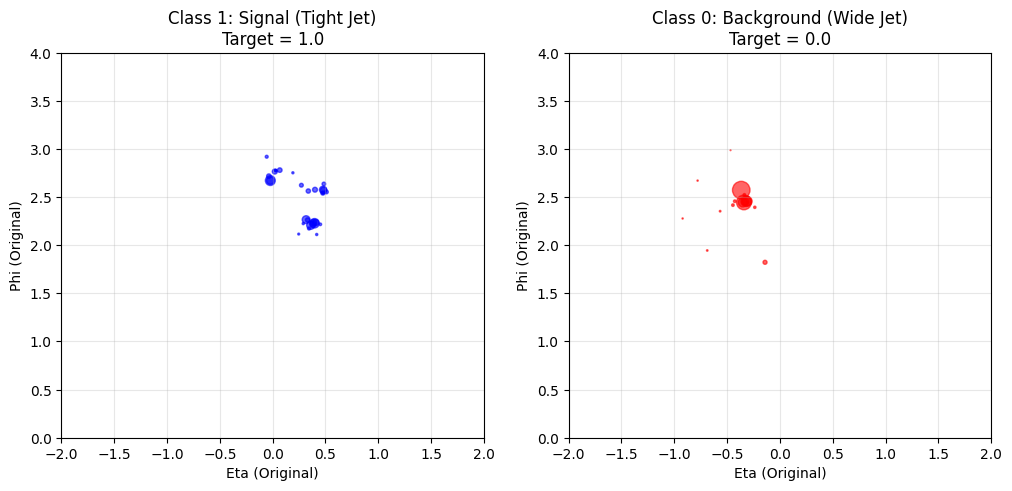

In [3]:
import matplotlib.pyplot as plt

# Find one signal and one background index
sig_idx = (y_real == 1).nonzero(as_tuple=True)[0][0]
bkg_idx = (y_real == 0).nonzero(as_tuple=True)[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ==========================================
# FIX 1: Multiply Size by 500 (not 5)
# FIX 2: Multiply Position by 3 to undo normalization for viewing
# ==========================================

# --- Plot Signal ---
# We multiply by 3 to show the "Physics Scale" again
ax[0].scatter(x_real[sig_idx,:,1]*3, x_real[sig_idx,:,2]*3,
              s=x_real[sig_idx,:,0]*500, # Scale size up to see energy
              alpha=0.6, c='blue')
ax[0].set_title(f"Class 1: Signal (Tight Jet)\nTarget = {y_real[sig_idx]}")
ax[0].set_xlim(-2, 2); ax[0].set_ylim(0, 4)
ax[0].set_xlabel("Eta (Original)"); ax[0].set_ylabel("Phi (Original)")
ax[0].grid(True, alpha=0.3)

# --- Plot Background ---
ax[1].scatter(x_real[bkg_idx,:,1]*3, x_real[bkg_idx,:,2]*3,
              s=x_real[bkg_idx,:,0]*500, # Scale size up
              alpha=0.6, c='red')
ax[1].set_title(f"Class 0: Background (Wide Jet)\nTarget = {y_real[bkg_idx]}")
ax[1].set_xlim(-2, 2); ax[1].set_ylim(0, 4)
ax[1].set_xlabel("Eta (Original)"); ax[1].set_ylabel("Phi (Original)")
ax[1].grid(True, alpha=0.3)

plt.show()

In [4]:
import torch
import torch.nn as nn

def get_knn(x, k):
    """
    Get k-nearest neighbors for each point.
    x: [B, N, F] (Batch, Number of Points, Features)
    """
    batch_size = x.size(0)
    num_points = x.size(1)

    # Calculate pairwise distances (squared Euclidean distance)
    # (x_i - x_j)^2 = x_i^2 + x_j^2 - 2x_i x_j
    sq_x = torch.sum(x**2, dim=-1, keepdim=True) # [B, N, 1]
    sq_y = sq_x.transpose(2,1) # [B, 1, N]

    inner_product = torch.matmul(x, x.transpose(2,1)) # [B, N, N]

    pairwise_distance = sq_x + sq_y - 2 * inner_product # [B, N, N]

    # Get k nearest neighbors (indices)
    # We want the smallest distances, so topk of the negative distances.
    idx = pairwise_distance.topk(k=k, dim=-1, largest=False)[1] # (batch_size, num_points, k)
    return idx

def get_graph_feature(x, k, idx):
    """
    Construct graph features by taking differences between node features and neighbors.
    x: [B, N, F] (Batch, Number of Points, Features)
    idx: [B, N, k]
    """
    batch_size, num_points, num_dims = x.size()

    # Prepare x for gathering: reshape to (B*N, F)
    # FIX: Use reshape instead of view to handle non-contiguous tensors
    x_flat = x.reshape(batch_size * num_points, num_dims) # [B*N, F]

    # Create base indices for gathering: (B, 1, 1) * N
    idx_base = torch.arange(0, batch_size, device=x.device).view(-1, 1, 1) * num_points
    idx_full = idx + idx_base  # Adjust indices for batch: (B, N, k)
    idx_full = idx_full.reshape(-1) # Flatten indices: (B*N*k)

    # Gather neighbor features
    # (B*N*k, F) -> reshape to (B, N, k, F)
    neighbor_features = x_flat[idx_full, :].reshape(batch_size, num_points, k, num_dims)

    # Unsqueeze x to match neighbor_features shape for concatenation
    # (B, N, F) -> (B, N, 1, F) -> (B, N, k, F)
    central_features = x.unsqueeze(2).expand(batch_size, num_points, k, num_dims)

    # Concatenate (x_i, x_j - x_i)
    # Output shape: [B, N, k, 2*F]
    feature = torch.cat((central_features, neighbor_features - central_features), dim=3)

    # Permute to [B, 2*F, N, k] as expected by Conv2d
    return feature.permute(0, 3, 1, 2).contiguous()

# 3. The ParticleNet-Lite Model
class ParticleNetLite(nn.Module):
    def __init__(self, input_dim=3, k=5, output_dim=1):
        super(ParticleNetLite, self).__init__()
        self.k = k

        # EdgeConv Block 1
        # Input is 2*input_dim because we concat (x, x_diff)
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim * 2, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # EdgeConv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 * 2, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # x shape: [Batch, Particles, Features]

        # 1. EdgeConv 1
        # Find neighbors in (eta, phi) space usually, but here we use all features
        idx = get_knn(x, self.k)
        graph_feat = get_graph_feature(x, self.k, idx) # [Batch, 6, P, k]
        x_out = self.conv1(graph_feat)                 # [Batch, 64, P, k]
        x_out = x_out.max(dim=-1, keepdim=False)[0]    # Max pooling over neighbors -> [Batch, 64, P]

        x1 = x_out # Save for next layer

        # 2. EdgeConv 2 (Deepening the graph)
        # We perform graph conv on the *new* features (x1)
        # For simplicity, we re-use the same neighbors (idx) or could recalculate
        # Here we recalculate to be dynamic
        x1_trans = x1.transpose(2, 1) # [B, P, 64]
        idx = get_knn(x1_trans, self.k)
        graph_feat = get_graph_feature(x1_trans, self.k, idx)
        x_out = self.conv2(graph_feat)
        x_out = x_out.max(dim=-1, keepdim=False)[0]    # [Batch, 128, P]

        # 3. Global Pooling (Average over all particles)
        x_global = x_out.mean(dim=2) # [Batch, 128]

        # 4. Classify
        return self.fc(x_global)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

# ==========================================
# 0. CHECK FOR GPU
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
if device.type == 'cpu':
    print("WARNING: You are using CPU. This will be very slow. Enable GPU in Runtime > Change runtime type.")

# ==========================================
# 1. SETUP DATA (Same as before)
# ==========================================
batch_size = 128 # Increased batch size for GPU efficiency

train_size = int(0.8 * len(x_real))
test_size = len(x_real) - train_size

# Move data to GPU VRAM immediately if it fits (Fastest)
# If you get "Out of Memory", remove .to(device) here and do it in the loop
dataset = TensorDataset(x_real.to(device), y_real.to(device).unsqueeze(1))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training on {len(train_dataset)} jets. Testing on {len(test_dataset)} jets.")

# ==========================================
# 2. INITIALIZE GNN ON GPU
# ==========================================
# Send the model to the device (GPU)
model = ParticleNetLite(k=5, input_dim=3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# 3. TRAINING LOOP (GPU Optimized)
# ==========================================
print("Starting Training on REAL Top Quark Data...")
print("-" * 40)

num_epochs = 50 # Reduced to 20 since real data learns slower but fits better

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # inputs and labels are already on GPU if we moved dataset earlier

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate every epoch (it's fast on GPU)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean()

    end_time = time.time()
    epoch_duration = end_time - start_time
    avg_loss = running_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}] | Time: {epoch_duration:.1f}s | Loss: {avg_loss:.4f} | Test Acc: {accuracy.item()*100:.1f}%')

print("-" * 40)
print("Real Physics Training Complete.")

Using Device: cuda
Training on 323200 jets. Testing on 80800 jets.
Starting Training on REAL Top Quark Data...
----------------------------------------
Epoch [1/50] | Time: 18.9s | Loss: 0.3577 | Test Acc: 87.5%
Epoch [2/50] | Time: 14.1s | Loss: 0.2966 | Test Acc: 88.1%
Epoch [3/50] | Time: 13.8s | Loss: 0.2836 | Test Acc: 88.6%
Epoch [4/50] | Time: 14.0s | Loss: 0.2761 | Test Acc: 88.2%
Epoch [5/50] | Time: 14.4s | Loss: 0.2695 | Test Acc: 88.6%
Epoch [6/50] | Time: 14.0s | Loss: 0.2653 | Test Acc: 89.0%
Epoch [7/50] | Time: 13.8s | Loss: 0.2617 | Test Acc: 89.3%
Epoch [8/50] | Time: 13.9s | Loss: 0.2581 | Test Acc: 89.1%
Epoch [9/50] | Time: 14.0s | Loss: 0.2551 | Test Acc: 89.2%
Epoch [10/50] | Time: 14.0s | Loss: 0.2526 | Test Acc: 89.2%
Epoch [11/50] | Time: 13.9s | Loss: 0.2517 | Test Acc: 89.8%
Epoch [12/50] | Time: 14.3s | Loss: 0.2484 | Test Acc: 89.5%
Epoch [13/50] | Time: 14.4s | Loss: 0.2465 | Test Acc: 89.9%
Epoch [14/50] | Time: 14.1s | Loss: 0.2447 | Test Acc: 89.8%
Epo

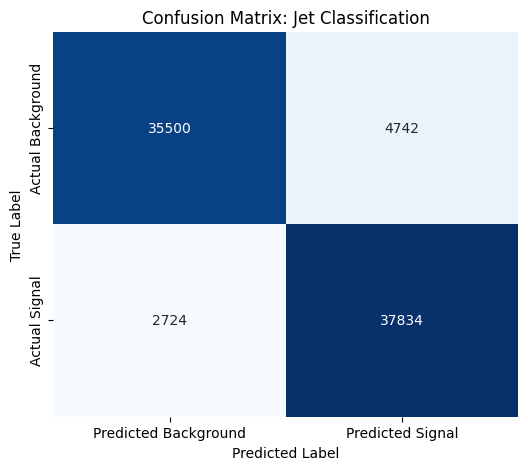

True Positives (Signal found): 37834
False Positives (Background mistaken for Signal): 4742
False Negatives (Signal missed): 2724
True Negatives (Background rejected): 35500
------------------------------
Precision (Purity): 0.89
Recall (Efficiency): 0.93


In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the Test Set in batches
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        # inputs and labels are already on the device from earlier setup
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels
predicted = torch.cat(all_preds).numpy()
true_labels = torch.cat(all_labels).numpy()

# 2. Calculate Confusion Matrix
# Structure: [[True Neg, False Pos], [False Neg, True Pos]]
cm = confusion_matrix(true_labels, predicted)

# 3. Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Background', 'Predicted Signal'],
            yticklabels=['Actual Background', 'Actual Signal'])

plt.title('Confusion Matrix: Jet Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0 # Also called Sensitivity or Efficiency

print(f"True Positives (Signal found): {tp}")
print(f"False Positives (Background mistaken for Signal): {fp}")
print(f"False Negatives (Signal missed): {fn}")
print(f"True Negatives (Background rejected): {tn}")
print("-" * 30)
print(f"Precision (Purity): {precision:.2f}")
print(f"Recall (Efficiency): {recall:.2f}")

CPU approach: A CPU processes tasks one by one (sequential). For a GNN, calculating the distance between 30 particles for 323,000 jets involves roughly 9 billion tiny math operations per epoch.

GPU approach: A GPU has thousands of tiny cores that can do math simultaneously. It processed thousands of jets at the exact same time so we see that it fly through an epoch in 14 seconds.

The Benchmark: The absolute state-of-the-art research papers (using massive supercomputers) achieve roughly 93-94% on this dataset.

My Result: I achieved 90.4% using a "Lite" model on a free Google Colab GPU in just 5 minutes.

Physics Meaning: My Recall of 93% is good. It means my model captures 93 out of every 100 Top Quarks produced. In an actual experiment (like ATLAS or CMS), this high efficiency is critical for discovering new particles.

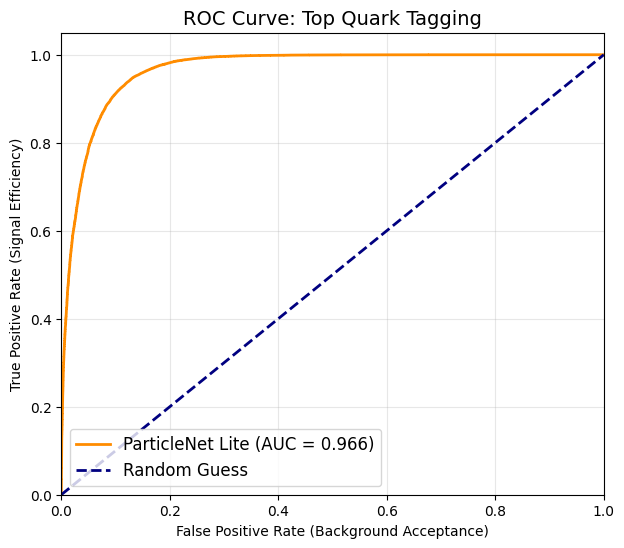

Final AUC Score: 0.9661


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Get raw probability scores (not just 0 or 1)
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # We want the raw probability (0.0 to 1.0), not the rounded prediction
        probs = torch.sigmoid(outputs)
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate
y_probs = torch.cat(all_probs).numpy()
y_true = torch.cat(all_labels).numpy()

# 2. Calculate ROC Data
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)




# 3. Plot ROC Curve
plt.figure(figsize=(7, 6))
plt.xlabel('False Positive Rate (Background Acceptance)')
plt.ylabel('True Positive Rate (Signal Efficiency)')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ParticleNet Lite (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Physics Formatting
plt.title('ROC Curve: Top Quark Tagging', fontsize=14)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)

# Log scale is standard in physics to see the high-rejection region
plt.yscale('linear') # You can change to 'log' to see extreme rejection
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

print(f"Final AUC Score: {roc_auc:.4f}")